In [2]:
s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [41]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_CnnPos_190505_0834 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_CnnPos_190505_0834/classes.json to temp/classes.json
download: s3://aegovan-data/results/model_CnnPos_190505_0834/feature_lens.json to temp/feature_lens.json
download: s3://aegovan-data/results/model_CnnPos_190505_0834/training_scores_epoch_Objectdump_20190505_125425_422de1cf-5585-44e9-8a5f-071065a4918c.json to temp/training_scores_epoch_Objectdump_20190505_125425_422de1cf-5585-44e9-8a5f-071065a4918c.json
download: s3://aegovan-data/results/model_CnnPos_190505_0834/validation_scores_epoch_Objectdump_20190505_125425_5f87a83f-2f3e-466a-8383-43c554e461e4.json to temp/validation_scores_epoch_Objectdump_20190505_125425_5f87a83f-2f3e-466a-8383-43c554e461e4.json
download: s3://aegovan-data/results/model_CnnPos_190505_0834/run.log to temp/run.log
download: s3://aegovan-data/results/model_CnnPos_190505_0834/predicted_test_unique_pub_v6_less_negative.json to temp/predicted_test_unique_pub_v6_less_negative.json
download: s3://aegovan-data/results/model_Cn

In [42]:
!ls  $data_dir

classes.json
feature_lens.json
predicted_test_unique_pub_v6_less_negative.json
predicted_val_unique_pub_v6_less_negative.json
run.log
training_scores_epoch_Objectdump_20190505_125425_422de1cf-5585-44e9-8a5f-071065a4918c.json
validation_scores_epoch_Objectdump_20190505_125425_5f87a83f-2f3e-466a-8383-43c554e461e4.json


In [43]:
!head -1 $data_dir/run.log 

commit 9f7e0f6a1f77887460650cccd3bf4dfb5fa8beff


In [44]:
!head -10 $data_dir/run.log | tail -8

Date:   Sun May 5 18:33:30 2019 +1000

    0.4.1 torch
{'network': 'CnnPos', 'trainjson': '/data/train_unique_pub_v6_less_negative.json', 'valjson': '/data/val_unique_pub_v6_less_negative.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_CnnPos_190505_0834', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-05-05 08:34:23,857 - __main__ - INFO - Running with interaction type None, network CnnPos
2019-05-05 08:34:24,061 - __main__ - INFO - Training shape (3639, 4), test shape (479, 4)
2019-05-05 08:34:24,061 - __main__ - INFO - The embedding header is 5443656 200



In [45]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [46]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [47]:
import glob

results_file = "./temp/predicted_test_unique_pub_v6_less_negative.json"
validation_fit_file = glob.glob("temp/validation_scores_epoch_Objectdump*.json")[0]
train_fit_file = glob.glob("temp/training_scores_epoch_Objectdump*.json")[0]


pos_label = True

In [48]:
#download_single_file(s3_data, results_file)

In [49]:
import pandas as pd

In [50]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [51]:
df_results.columns


Index(['entityMentionsCount', 'hasTriggerWord', 'interactionId',
       'interactionType', 'isValid', 'lessThanThreshold', 'participant1Alias',
       'participant1Id', 'participant2Alias', 'participant2Id',
       'participants_count', 'pubmedId', 'pubmedTitle', 'pubmedabstract',
       'normalised_abstract', 'particpant1Exists', 'particpant2Exists',
       'bothParticpantsExist', 'noParticpantsExist', 'predicted',
       'confidence_scores', 'confidence_true', 'confidence_false', 'actual'],
      dtype='object')

## Analyse Results

In [52]:
df = df_results

In [53]:
df_results.shape

(999, 24)

In [54]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
0,0.765973,0.234027,False,True,"{'False': -1.452316761, 'True': -0.2666089535}"
578,0.765973,0.234027,False,True,"{'False': -1.452316761, 'True': -0.2666089535}"
580,0.765973,0.234027,False,True,"{'False': -1.452316761, 'True': -0.2666089535}"


In [71]:
df['fake_interactionType'] = df['interactionId'].str.contains('fake_interaction')
df['fake_entitypair'] = df['interactionId'].str.contains('fake_annot')

The accuracy is 0.5712209302325582


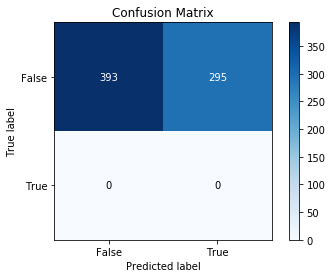

In [81]:
from sklearn.metrics import f1_score, accuracy_score
fake = df.query('fake_entitypair')

accuracy = accuracy_score(fake["actual"], fake["predicted"], sample_weight=None)
print("The accuracy is {}".format( accuracy))

import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(fake["actual"], fake["predicted"], normalize=False )
plt.show()

The accuracy is 0.49523809523809526


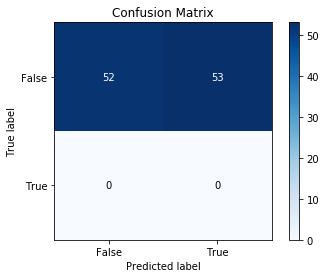

In [83]:
fake = df.query('fake_interactionType')

accuracy = accuracy_score(fake["actual"], fake["predicted"], sample_weight=None)
print("The accuracy is {}".format( accuracy))


import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(fake["actual"], fake["predicted"], normalize=False )
plt.show()

In [56]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"])  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.3083969465648855 and the accuracy is 0.5465465465465466


In [57]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


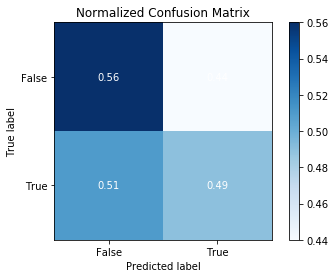

In [58]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

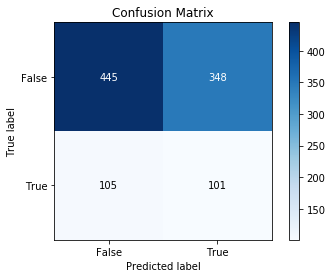

In [59]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

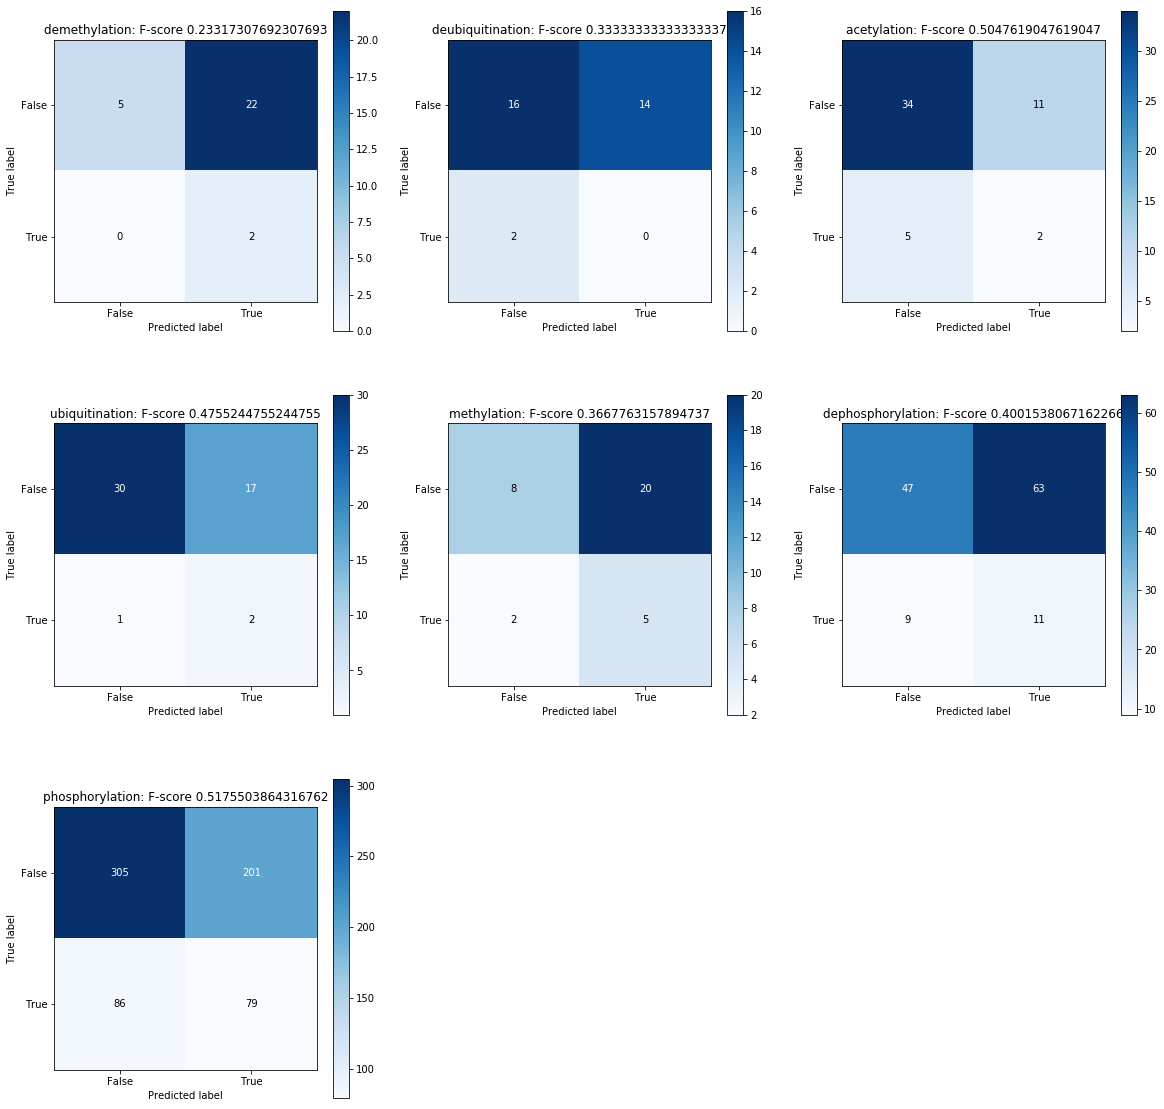

In [86]:
interactions = df["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3, 3)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    r = i//3
    c= i % 3
    df_interaction_type = df.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[r, c])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    
    


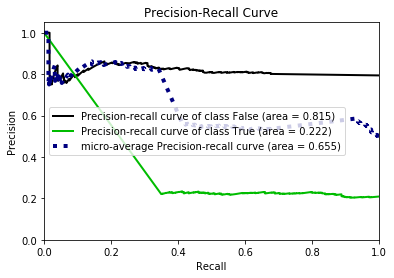

In [61]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [62]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [63]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
191,191,0.850783,0.653035,0.703857,0.609058
179,179,0.845012,0.650558,0.677419,0.625745
187,187,0.849409,0.650064,0.700138,0.606675
195,195,0.849134,0.648302,0.700831,0.603099
194,194,0.849684,0.648232,0.703911,0.600715
198,198,0.848310,0.643411,0.702398,0.593564
197,197,0.844188,0.641819,0.682796,0.605483
186,186,0.845562,0.640665,0.691034,0.597139
192,192,0.846936,0.638077,0.701429,0.585221
190,190,0.845012,0.637066,0.692308,0.589988


In [64]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
186,186,0.505219,0.350685,0.246154,0.609524
120,120,0.526096,0.342029,0.245833,0.561905
176,176,0.498956,0.333333,0.235294,0.571429
172,172,0.513570,0.324638,0.233333,0.533333
165,165,0.521921,0.324484,0.235043,0.523810
54,54,0.588727,0.323024,0.252688,0.447619
146,146,0.488518,0.321330,0.226562,0.552381
170,170,0.534447,0.318043,0.234234,0.495238
166,166,0.524008,0.317365,0.231441,0.504762
154,154,0.513570,0.316716,0.228814,0.514286


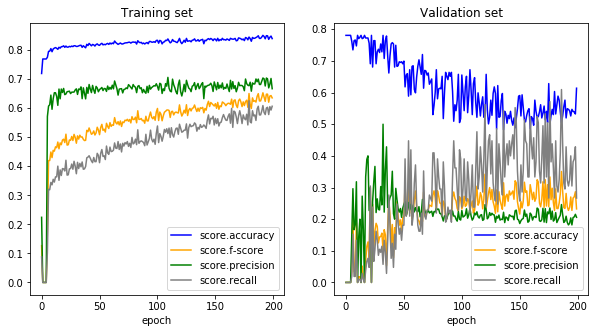

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score.f-score", ax = ax[0], color="orange")
df_train_fit.plot.line(x="epoch", y="score.precision", ax = ax[0], color ="green")
df_train_fit.plot.line(x="epoch", y="score.recall", ax = ax[0], color ="gray")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score.f-score", ax = ax[1], color ="orange")
df_val_fit.plot.line(x="epoch", y="score.precision", ax = ax[1], color ="green")
df_val_fit.plot.line(x="epoch", y="score.recall", ax = ax[1], color ="gray")
ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [66]:
threshold = .78
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(0, 26)

In [67]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

The F1 score is 0.0 and the accuracy is nan


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    

<Figure size 2880x2880 with 0 Axes>